# Introduction
In this notebook, we analyse the relationships between individual Option Greeks with individual factors that influence **European (Calls) options** prices according to the Black-Scholes option pricing model.

# Black-Scholes
The Black-Scholes model is a mathematical equation that estimates the theoretical value of derivatives (mainly options), taking into account the impact of time and other risk factors:

$$C=S\times N(d_1)-K\times e^{-rT}\times N(d_2)$$

where:
- $d_1=\frac{ln^S_K+(r+\frac{\sigma^2_v}{2})t}{\sigma_s\sqrt{T}}$
- $d_2=d_1-\sigma_s\sqrt{T}$

and:
- $C$ = Call option price
- $S$ = Spot price
- $K$ = Strike price
- $r$ = Risk-free interest rate (%)
- $T$ = Time to maturity (years)
- $\sigma$ = Volatility (%)
- $N$ = A normal distribution, typically with mean 0 and standard deviation 1

Note: Our Black-Scholes implementation will have a time input in days instead of years.

In [204]:
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt

In [205]:
N = norm.cdf

def d1(S, K, r, T, sigma):
    return (np.log(S/K) + (r + sigma**2/2)*T) / (sigma*np.sqrt(T))

def d2(S, K, r, T, sigma):
    return d1(S, K, r, T, sigma) - sigma * np.sqrt(T)

def BS_CALL(S, K, T, r, sigma):
    d1_value = d1(S, K, r, T, sigma)
    d2_value = d2(S, K, r, T, sigma)
    return S * N(d1_value) - K * np.exp(-r*T)* N(d2_value)

def BS_PUT(S, K, T, r, sigma):
    d1_value = d1(S, K, r, T, sigma)
    d2_value = d2(S, K, r, T, sigma)
    return K*np.exp(-r*T)*N(-d2_value) - S*N(-d1_value)

# Constant Variables for Analysis
Throughout this analysis of Option greeks, we will assume the following default values for each factor that drives options prices:

In [206]:
S = 100         # Spot price (Change this to analyse ATM, OTM and ITM options)
K = 100         # Strike price
t = 30          # Time to maturity in DAYS
r = 0.05        # Risk-free interest rate
sigma = 0.5     # Volatility of the underlying

# Delta
Delta measures the amount of change in option price for a $1 increase in the underlying.

E.g. ABC stock is trading at $100 per share. A CALL ABC option is trading at $10 per share. If Delta = 0.5, then:
- If ABC increases to $101, CALL ABC increases to $10.5.
- If ABC decreases to $99, CALL ABC decreases to $9.5.

## Deriving Delta
Since delta measures the rate of change of the option's price w.r.t. the underlying's price, we can express delta as:
$$\Delta=\frac{\partial C}{\partial S}=N^{'}(d_1)S$$
where $N^{'}(d_1)$ is the probability density function (PDF) of the standard normal distribution, which is the derivative of $N(d_1)$ w.r.t. to $d_1$:
$$N^{'}(d_1)=\frac{e^{-\frac{d_1^2}{2}}}{\sqrt{2\pi}}$$
Then for an European Call:
$$\Delta_{call}=N(d_1)$$
For an European Put:
$$\Delta_{put}=N(d_1)-1$$

In [207]:
def delta_call(S, K, r, T, sigma):
    d1_value = d1(S, K, r, T, sigma)
    return norm.cdf(d1_value)

## Delta vs. Spot Price

In [208]:
def delta_spot_analysis(K, r, t, sigma):
    T = t / 365
    S = np.arange(K * 0.5, K * 1.5, 1)
    calls_deltas = delta_call(S, K, r, T, sigma)

    plt.title('CALL Delta vs. Spot Price')
    plt.plot(S, calls_deltas, label='Delta')
    plt.xlabel('Spot Price')
    plt.ylabel('CALL Delta')

    # Add vertical dotted lines for OTM, ATM, and ITM options
    label_offset = 0.005  # Adjust this value to change the distance between the line and the label
    plt.text(S[0] + label_offset, calls_deltas[0], 'Delta', verticalalignment='bottom', horizontalalignment='left')

    # Add vertical dotted lines
    plt.axvline(x=80, color='gray', linestyle='--')
    plt.axvline(x=100, color='gray', linestyle='--')
    plt.axvline(x=120, color='gray', linestyle='--')

    # Add labels for the dotted lines
    plt.text(80, 0.5, 'OTM', color='gray', verticalalignment='bottom', horizontalalignment='right')
    plt.text(100, 0.5, 'ATM', color='gray', verticalalignment='bottom', horizontalalignment='right')
    plt.text(120, 0.5, 'ITM', color='gray', verticalalignment='bottom', horizontalalignment='right')

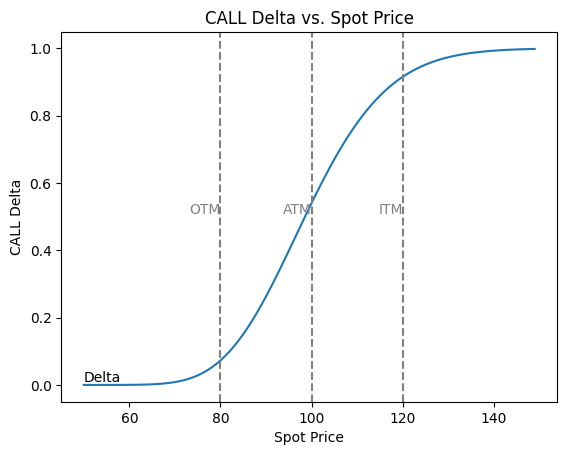

In [209]:
delta_spot_analysis(K, r, t, sigma)

## Delta vs. Time


In [210]:
def delta_time_analysis(S, K, r, sigma, moneyness):
    times = np.arange(100, 0, -1)
    calls_deltas = [delta_call(S, K, r, t/365, sigma) for t in times]

    plt.title(f'{moneyness} CALL Delta vs. Time')
    plt.plot(times, calls_deltas, label=f'{moneyness} Delta')
    plt.xlabel('Time (days)')
    plt.gca().invert_xaxis()
    plt.ylabel('CALL Delta')
    plt.legend()

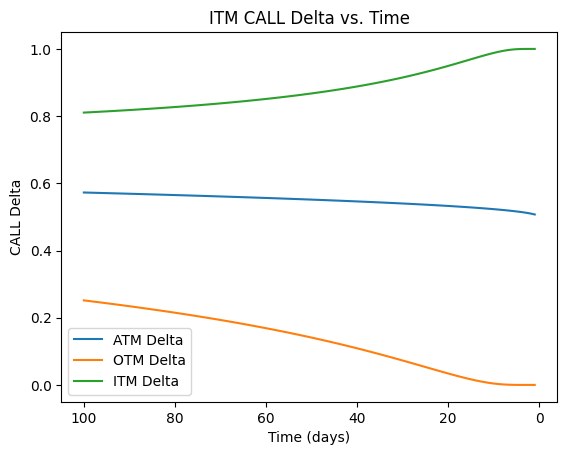

In [211]:
delta_time_analysis(S, K, r, sigma, moneyness="ATM")
delta_time_analysis(S-20, K, r, sigma, moneyness="OTM")
delta_time_analysis(S+20, K, r, sigma, moneyness="ITM")

## Delta vs Volatility

In [320]:
def delta_volatility_analysis(S, K, r, t, vol):
    S = np.arange(K * 0.5, K * 1.5, 1)
    calls_deltas = delta_call(S, K, r, t/365, vol)
    plt.plot(S, calls_deltas, label=f'Delta (Volatility {int(vol * 100)}%)')

    plt.title('CALL Delta vs. Volatility')
    
    plt.xlabel('Spot price')
    plt.ylabel('CALL Delta')
    plt.legend()

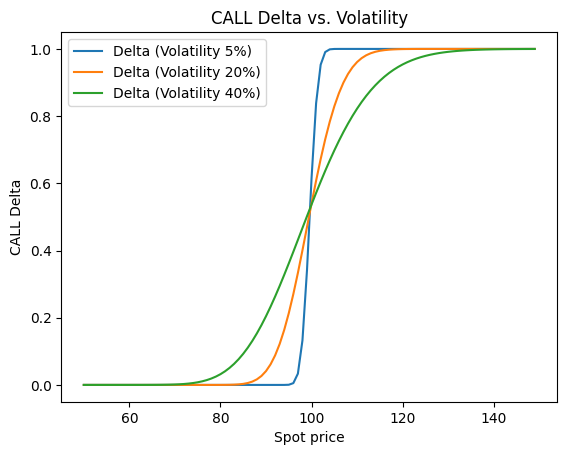

In [321]:
delta_volatility_analysis(S, K, r, t, vol=0.05)
delta_volatility_analysis(S, K, r, t, vol=0.2)
delta_volatility_analysis(S, K, r, t, vol=0.4)

# Gamma
Gamma measures the amount of change in Delta for a $1 increase in the underlying.

E.g. ABC stock is trading at $100 per share. A CALL ABC option is trading at $10 per share. If Delta = 0.5 and Gamma = 0.15, then:
- If ABC increases to $101, CALL ABC increases to $10.5 and delta increases to 0.65.
- If ABC decreases to $99, CALL ABC decreases to $9.5 and delta decreases to 0.35.

## Deriving Gamma
Gamma measures the rate of change of delta. From above, we already know the formula for calculating Delta. To find gamma, we simply differentiate Delta w.r.t. the underlying price S again:
$$\Gamma=\frac{\partial\Delta}{\partial S}=\frac{\partial^2C}{\partial S^2}=\frac{\partial}{\partial S}N^{'}(d_1)S=N^{'}(d_1)$$
which evaluates to:
$$\Gamma=\frac{e^{-\frac{d_1^2}{2}}}{S\times\sigma\times\sqrt{T}}$$
where $e^{-\frac{d_1^2}{2}}$ is $N^{'}(d_1)$.

In [322]:
def gamma_call(S, K, r, T, sigma):
    d1_value = d1(S, K, r, T, sigma)
    return norm.pdf(d1_value) / (S * sigma * np.sqrt(T))

## Gamma vs. Spot Price

In [323]:
def gamma_spot_analysis(K, r, t, sigma):
    T = t / 365
    S = np.arange(K * 0.5, K * 1.5, 1)
    calls_gammas = gamma_call(S, K, r, T, sigma)

    plt.title('CALL Gamma vs. Spot Price')
    plt.plot(S, calls_gammas, label='Gamma')
    plt.xlabel('Spot Price')
    plt.ylabel('CALL Gamma')
    plt.legend()

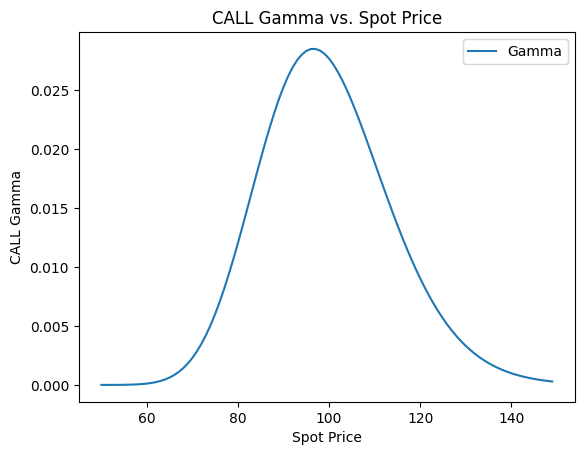

In [324]:
gamma_spot_analysis(K, r, t, sigma)

## Gamma vs. Time

In [325]:
def gamma_time_analysis(S, K, r, sigma, moneyness):
    times = np.arange(100, 0, -1)
    calls_gammas = [gamma_call(S, K, r, t/365, sigma) for t in times]

    plt.title(f'{moneyness} CALL Gamma vs. Time')
    plt.plot(times, calls_gammas, label=f'{moneyness} Gamma')
    plt.xlabel('Time (days)')
    plt.gca().invert_xaxis()
    plt.ylabel('CALL Gamma')
    plt.legend()

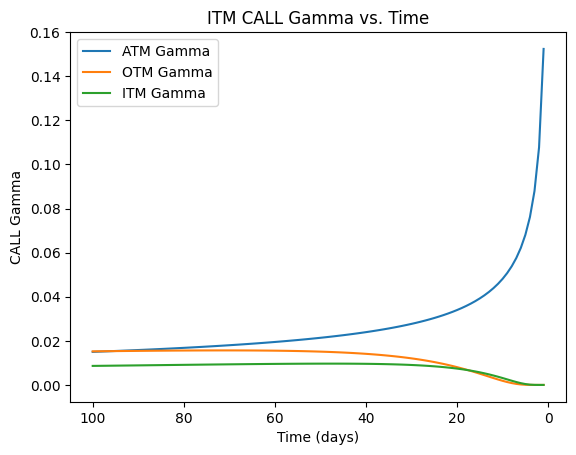

In [326]:
gamma_time_analysis(S, K, r, sigma, moneyness='ATM')
gamma_time_analysis(S-20, K, r, sigma, moneyness='OTM')
gamma_time_analysis(S+20, K, r, sigma, moneyness='ITM')

## Gamma vs. Volatility

In [338]:
def gamma_volatility_analysis(S, K, r, t, vol):
    S = np.arange(K * 0.5, K * 1.5, 1)
    calls_gammas = gamma_call(S, K, r, t/365, vol)
    plt.plot(S, calls_gammas, label=f'Gamma (Volatility {int(vol * 100)}%)')

    plt.title('CALL Gamma vs. Volatility')
    
    plt.xlabel('Spot price')
    plt.ylabel('CALL Gamma')
    plt.legend()

    # Add vertical dotted lines
    plt.axvline(x=80, color='gray', linestyle='--')
    plt.axvline(x=100, color='gray', linestyle='--')
    plt.axvline(x=120, color='gray', linestyle='--')

    # Add labels for the dotted lines
    plt.text(80, 0.1, 'ITM', color='gray', verticalalignment='bottom', horizontalalignment='right')
    plt.text(100, 0.1, 'ATM', color='gray', verticalalignment='bottom', horizontalalignment='right')
    plt.text(120, 0.1, 'OTM', color='gray', verticalalignment='bottom', horizontalalignment='right')

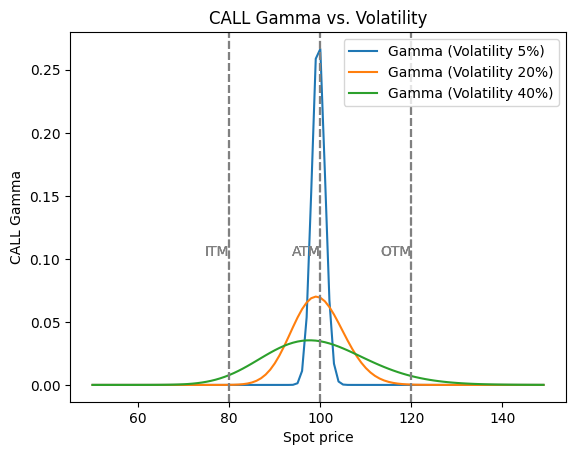

In [339]:
gamma_volatility_analysis(S, K, r, t, vol=0.05)
gamma_volatility_analysis(S, K, r, t, vol=0.2)
gamma_volatility_analysis(S, K, r, t, vol=0.4)

# Vega
Vega measures the amount of change in option prices for a 1% increase in volatility:

$$v_{call/put}=S\times N^{'}(d_1)\times\sqrt{T}$$

In [340]:
def vega(S, K, r, T, sigma):
    d1_value = d1(S, K, r, T, sigma)
    return S * norm.pdf(d1_value) * np.sqrt(T)

## Vega vs. Spot Price

In [355]:
def vega_spot_analysis(K, r, t, sigma):
    T = t / 365
    S = np.arange(K * 0.5, K * 1.5, 1)
    calls_vegas = vega(S, K, r, T, sigma)

    plt.title('CALL/PUT Vega vs. Spot Price')
    plt.plot(S, calls_vegas, label=f'CALL {K} Vega')
    plt.xlabel('Spot Price')
    plt.ylabel('CALL Vega')
    plt.legend()

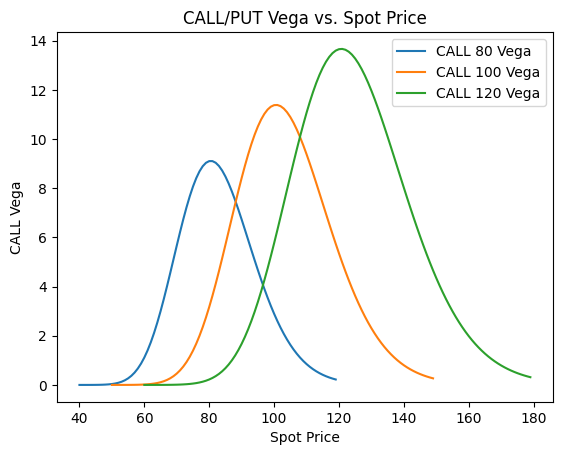

In [356]:
vega_spot_analysis(K-20, r, t, sigma)
vega_spot_analysis(K, r, t, sigma)
vega_spot_analysis(K+20, r, t, sigma)

## Vega vs. Time

In [357]:
def vega_time_analysis(S, K, r, sigma, t):
    T = t / 365
    S = np.arange(K * 0.5, K * 1.5, 1)
    calls_vegas = vega(S, K, r, T, sigma)

    plt.title('Vega vs. Different days till expiration')
    plt.plot(S, calls_vegas, label=f'{t} days till expiration')
    plt.xlabel('Spot Price')
    plt.ylabel('Vega')
    plt.legend()

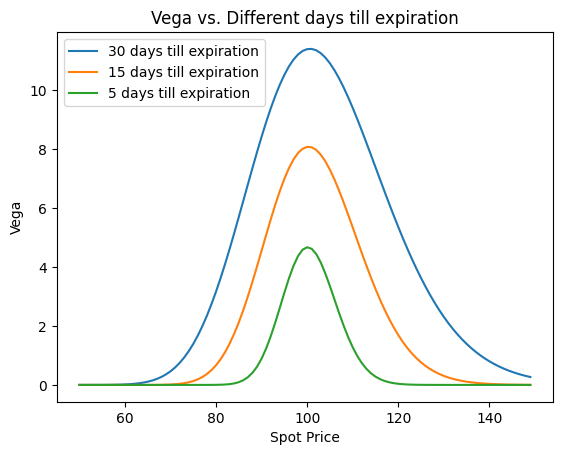

In [358]:
vega_time_analysis(S, K, r, sigma, t)
vega_time_analysis(S, K, r, sigma, t-15)
vega_time_analysis(S, K, r, sigma, t-25)

# Theta

$$\theta_{call}=-\frac{S\times N^{'}(d_1)\times\sigma}{2\sqrt{T}}-r\times K\times e^{-rT}\times N(d_2)$$

$$\theta_{put}=-\frac{S\times N^{'}(d_1)\times\sigma}{2\sqrt{T}}-r\times K\times e^{-rT}\times N(-d_2)$$

In [359]:
def theta_call(S, K, r, T, sigma):
    d1_value = d1(S, K, r, T, sigma)
    d2_value = d2(S, K, r, T, sigma)
    return (-S * norm.pdf(d1_value) * sigma / (2 * np.sqrt(T))) - (r * K * np.exp(-r * T) * norm.cdf(d2_value))

def theta_put(S, K, r, T, sigma):
    d1_value = d1(S, K, r, T, sigma)
    d2_value = d2(S, K, r, T, sigma)
    return (-S * norm.pdf(d1_value) * sigma / (2 * np.sqrt(T))) + (r * K * np.exp(-r * T) * norm.cdf(-d2_value))

## Theta vs. Spot Price

In [360]:
def theta_spot_analysis(K, r, t, sigma):
    T = t / 365
    S = np.arange(K * 0.5, K * 1.5, 1)
    calls_thetas = theta_call(S, K, r, T, sigma)

    plt.title('CALL Theta vs. Spot Price')
    plt.plot(S, calls_thetas, label='Theta')
    plt.xlabel('Spot Price')
    plt.ylabel('CALL Theta')
    plt.legend()

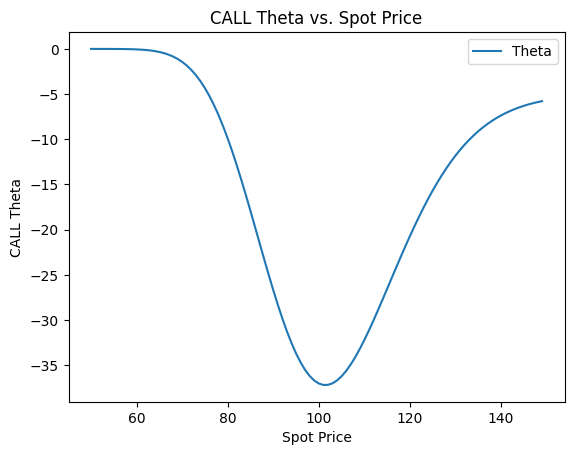

In [361]:
theta_spot_analysis(K, r, t, sigma)

## Theta vs. Volatility

In [366]:
def theta_volatility_analysis(K, r, t, vol):
    T = t / 365
    S = np.arange(K * 0.5, K * 1.5, 1)
    calls_thetas = theta_call(S, K, r, T, vol)

    plt.title('CALL Theta vs. Volatility')
    plt.plot(S, calls_thetas, label=f'Theta (Volatility {int(vol * 100)}%)')
    plt.xlabel('Spot Price')
    plt.ylabel('CALL Theta')
    plt.legend()

def gamma_volatility_analysis(S, K, r, t, vol):
    S = np.arange(K * 0.5, K * 1.5, 1)
    calls_gammas = gamma_call(S, K, r, t/365, vol)
    plt.plot(S, calls_gammas, label=f'Gamma (Volatility {int(vol * 100)}%)')

    plt.title('CALL Gamma vs. Volatility')
    
    plt.xlabel('Spot price')
    plt.ylabel('CALL Gamma')
    plt.legend()

    # Add vertical dotted lines
    plt.axvline(x=80, color='gray', linestyle='--')
    plt.axvline(x=100, color='gray', linestyle='--')
    plt.axvline(x=120, color='gray', linestyle='--')

    # Add labels for the dotted lines
    plt.text(80, 0.1, 'ITM', color='gray', verticalalignment='bottom', horizontalalignment='right')
    plt.text(100, 0.1, 'ATM', color='gray', verticalalignment='bottom', horizontalalignment='right')
    plt.text(120, 0.1, 'OTM', color='gray', verticalalignment='bottom', horizontalalignment='right')

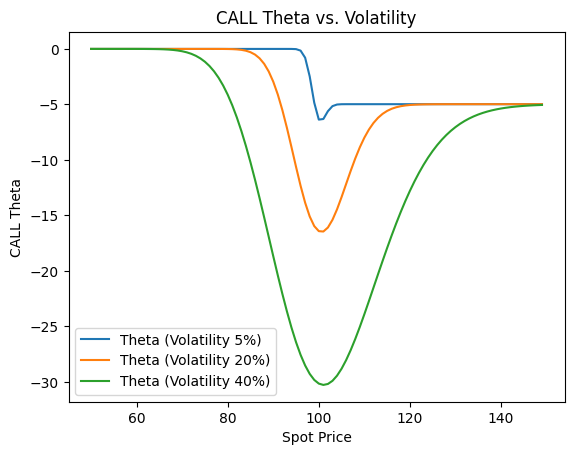

In [367]:
theta_volatility_analysis(K, r, t, vol=0.05)
theta_volatility_analysis(K, r, t, vol=0.2)
theta_volatility_analysis(K, r, t, vol=0.4)